<font size="+3">Time-series Generative Adversarial Network (TimeGAN)</font>

# Imports & Settings

Adapted from the excellent paper by Jinsung Yoon, Daniel Jarrett, and Mihaela van der Schaar:  
[Time-series Generative Adversarial Networks](https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks),  
Neural Information Processing Systems (NeurIPS), 2019.

- Last updated Date: April 24th 2020
- [Original code](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/alg/timegan/) author: Jinsung Yoon (jsyoon0823@gmail.com)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

In [4]:
sns.set_style('whitegrid')

# Experiment Path

In [5]:
path = Path('time_gan')

In [6]:
experiment = 0

In [7]:
log_dir = path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

In [8]:
hdf_store = path / 'TimeSeriesGAN.h5'

# Prepare Data

## Parameters

In [9]:
seq_len = 24
n_seq = 6
batch_size = 128

In [10]:
tickers = ['BA', 'CAT', 'DIS', 'GE', 'IBM', 'KO']

In [11]:
def select_data():
    df = (pd.read_hdf('../data/assets.h5', 'quandl/wiki/prices')
          .adj_close
          .unstack('ticker')
          .loc['2000':, tickers]
          .dropna())

    df.to_hdf(hdf_store, 'data/real')

## Plot Series

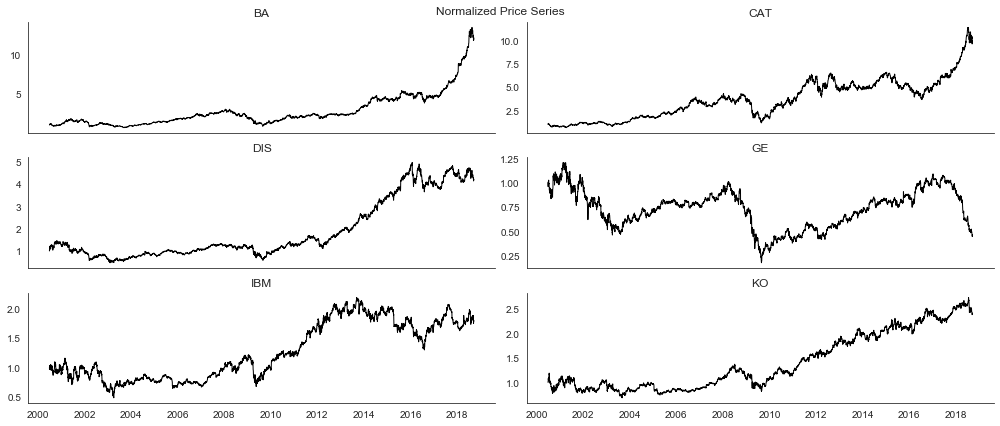

In [87]:
sns.set_style('white')
df = pd.read_hdf(hdf_store, 'data/real')
axes = df.div(df.iloc[0]).plot(subplots=True,
                               figsize=(14, 6),
                               layout=(3, 2),
                               title=tickers,
                               legend=False,
                               rot=0,
                               lw=1, 
                               color='k')
for ax in axes.flatten():
    ax.set_xlabel('')
plt.suptitle('Normalized Price Series')
plt.gcf().tight_layout()
sns.despine();

## Correlation

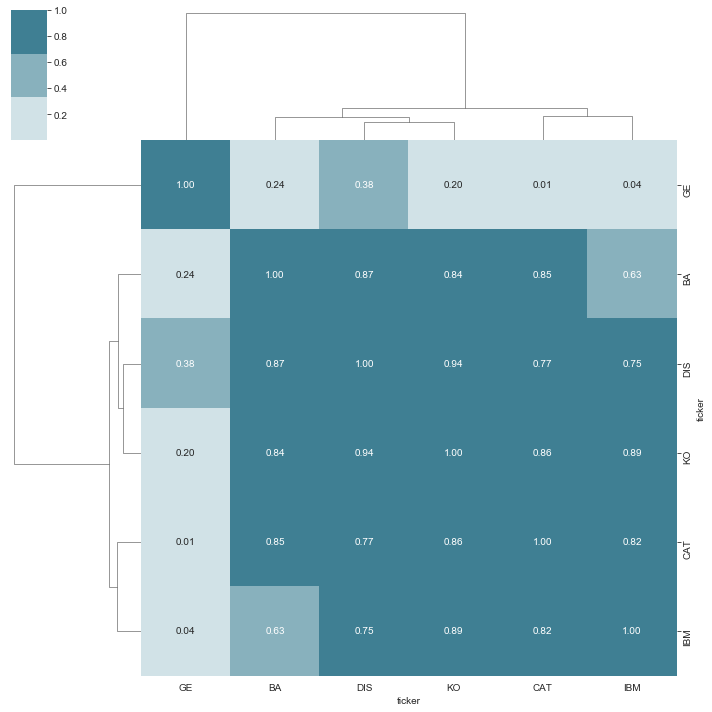

In [13]:
sns.clustermap(df.corr(),
               annot=True,
               fmt='.2f',
               cmap=sns.diverging_palette(h_neg=20,
                                          h_pos=220), center=0);

## Normalize Data

In [14]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

## Create rolling window sequences

In [15]:
data = []
for i in range(len(df) - seq_len):
    data.append(scaled_data[i:i + seq_len])

n_windows = len(data)

## Create tf.data.Dataset

In [16]:
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle(buffer_size=n_windows)
               .batch(batch_size))
real_series_iter = iter(real_series.repeat())

## Set up random series generator

In [17]:
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

We use the Python generator to feed a `tf.data.Dataset` that continues to call the random number generator as long as necessary and produces the desired batch size.

In [18]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

# TimeGAN Components

The design of the TimeGAN components follows the author's sample code.

##  Network Parameters

In [19]:
hidden_dim = 24
num_layers = 3

## Set up logger

In [20]:
writer = tf.summary.create_file_writer(log_dir.as_posix())

## Input place holders

In [21]:
X = Input(shape=[seq_len, n_seq], name='RealData')
Z = Input(shape=[seq_len, n_seq], name='RandomData')

## RNN block generator

We keep it very simple and use a very similar architecture for all four components. For a real-world application, they should be tailored to the data.

In [22]:
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                           return_sequences=True,
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

## Embedder & Recovery

In [23]:
embedder = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim, 
                    name='Embedder')
recovery = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=n_seq, 
                    name='Recovery')

## Generator & Discriminator

In [24]:
generator = make_rnn(n_layers=3, 
                     hidden_units=hidden_dim, 
                     output_units=hidden_dim, 
                     name='Generator')
discriminator = make_rnn(n_layers=3, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name='Discriminator')
supervisor = make_rnn(n_layers=2, 
                      hidden_units=hidden_dim, 
                      output_units=hidden_dim, 
                      name='Supervisor')

# TimeGAN Training

## Settings

In [25]:
train_steps = 10000
gamma = 1

## Generic Loss Functions

In [26]:
mse = MeanSquaredError()
bce = BinaryCrossentropy()

# Phase 1: Autoencoder Training

## Architecture

In [27]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name='Autoencoder')

In [28]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RealData (InputLayer)        [(None, 24, 6)]           0         
_________________________________________________________________
Embedder (Sequential)        (None, 24, 24)            10104     
_________________________________________________________________
Recovery (Sequential)        (None, 24, 6)             10950     
Total params: 21,054
Trainable params: 21,054
Non-trainable params: 0
_________________________________________________________________


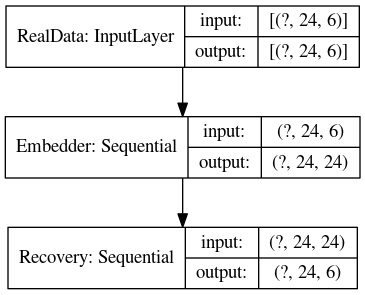

In [29]:
plot_model(autoencoder, show_shapes=True)

## Autoencoder Optimizer

In [30]:
autoencoder_optimizer = Adam()

## Autoencoder Training Step

In [31]:
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Autoencoder Training Loop

In [32]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

100%|██████████| 10000/10000 [01:07<00:00, 148.90it/s]


## Persist model

In [33]:
# autoencoder.save(log_dir / 'autoencoder')

# Phase 2: Supervised training

## Define Optimizer

In [34]:
supervisor_optimizer = Adam()

## Train Step

In [35]:
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

## Training Loop

In [36]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

100%|██████████| 10000/10000 [02:42<00:00, 61.36it/s]


## Persist Model

In [37]:
# supervisor.save(log_dir / 'supervisor')

# Joint Training

## Generator

### Adversarial Architecture - Supervised

In [38]:
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [39]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RandomData (InputLayer)      [(None, 24, 6)]           0         
_________________________________________________________________
Generator (Sequential)       (None, 24, 24)            10104     
_________________________________________________________________
Supervisor (Sequential)      (None, 24, 24)            7800      
_________________________________________________________________
Discriminator (Sequential)   (None, 24, 1)             10825     
Total params: 28,729
Trainable params: 28,729
Non-trainable params: 0
_________________________________________________________________


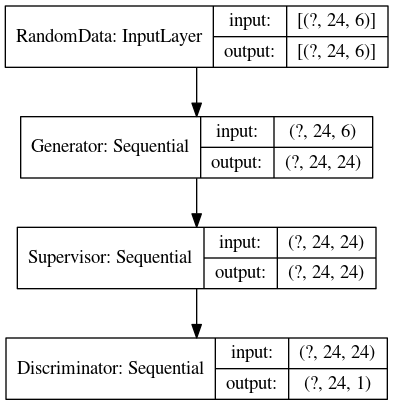

In [40]:
plot_model(adversarial_supervised, show_shapes=True)

### Adversarial Architecture in Latent Space

In [41]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')

In [42]:
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RandomData (InputLayer)      [(None, 24, 6)]           0         
_________________________________________________________________
Generator (Sequential)       (None, 24, 24)            10104     
_________________________________________________________________
Discriminator (Sequential)   (None, 24, 1)             10825     
Total params: 20,929
Trainable params: 20,929
Non-trainable params: 0
_________________________________________________________________


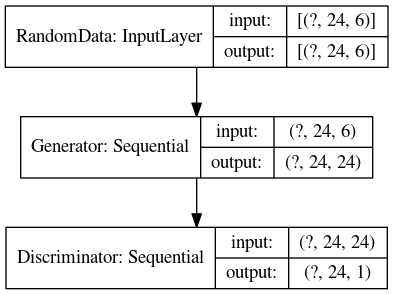

In [43]:
plot_model(adversarial_emb, show_shapes=True)

### Mean & Variance Loss

In [44]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name='SyntheticData')

In [45]:
synthetic_data.summary()

Model: "SyntheticData"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RandomData (InputLayer)      [(None, 24, 6)]           0         
_________________________________________________________________
Generator (Sequential)       (None, 24, 24)            10104     
_________________________________________________________________
Supervisor (Sequential)      (None, 24, 24)            7800      
_________________________________________________________________
Recovery (Sequential)        (None, 24, 6)             10950     
Total params: 28,854
Trainable params: 28,854
Non-trainable params: 0
_________________________________________________________________


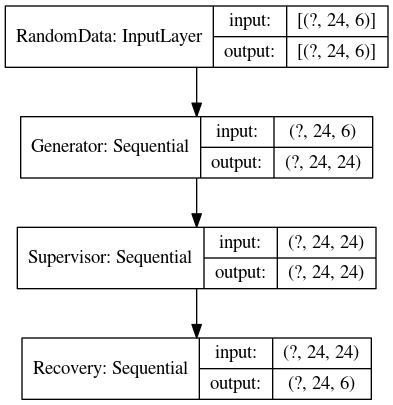

In [46]:
plot_model(synthetic_data, show_shapes=True)

In [47]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

## Discriminator

### Architecture: Real Data

In [48]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')

In [49]:
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RealData (InputLayer)        [(None, 24, 6)]           0         
_________________________________________________________________
Embedder (Sequential)        (None, 24, 24)            10104     
_________________________________________________________________
Discriminator (Sequential)   (None, 24, 1)             10825     
Total params: 20,929
Trainable params: 20,929
Non-trainable params: 0
_________________________________________________________________


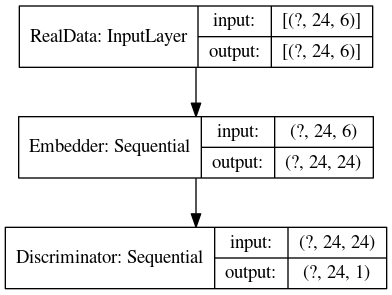

In [50]:
plot_model(discriminator_model, show_shapes=True)

## Optimizers

In [51]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

## Generator Train Step

In [52]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

## Embedding Train Step

In [53]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Discriminator Train Step

In [54]:
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

In [55]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

## Training Loop

In [56]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)

     0 | d_loss: 2.2301 | g_loss_u: 0.5783 | g_loss_s: 0.0004 | g_loss_v: 0.3625 | e_loss_t0: 0.0555
 1,000 | d_loss: 1.5480 | g_loss_u: 1.3529 | g_loss_s: 0.0002 | g_loss_v: 0.0289 | e_loss_t0: 0.0102
 2,000 | d_loss: 1.2685 | g_loss_u: 1.2955 | g_loss_s: 0.0001 | g_loss_v: 0.0364 | e_loss_t0: 0.0092
 3,000 | d_loss: 1.3891 | g_loss_u: 1.4064 | g_loss_s: 0.0002 | g_loss_v: 0.0337 | e_loss_t0: 0.0086
 4,000 | d_loss: 1.5756 | g_loss_u: 1.6539 | g_loss_s: 0.0001 | g_loss_v: 0.0385 | e_loss_t0: 0.0073
 5,000 | d_loss: 1.4631 | g_loss_u: 1.4369 | g_loss_s: 0.0001 | g_loss_v: 0.0366 | e_loss_t0: 0.0064
 6,000 | d_loss: 1.4675 | g_loss_u: 1.5706 | g_loss_s: 0.0002 | g_loss_v: 0.0980 | e_loss_t0: 0.0054
 7,000 | d_loss: 1.3753 | g_loss_u: 1.6165 | g_loss_s: 0.0001 | g_loss_v: 0.0308 | e_loss_t0: 0.0049
 8,000 | d_loss: 1.2322 | g_loss_u: 1.5210 | g_loss_s: 0.0001 | g_loss_v: 0.0426 | e_loss_t0: 0.0047
 9,000 | d_loss: 1.2591 | g_loss_u: 1.6334 | g_loss_s: 0.0001 | g_loss_v: 0.0287 | e_loss_t

## Perist Synthetic Data Generator

In [57]:
synthetic_data.save(log_dir / 'synthetic_data')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: time_gan/experiment_01/synthetic_data/assets


# Generate Synthetic Data

In [58]:
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [59]:
len(generated_data)

35

In [60]:
35 * 128

4480

In [61]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(4480, 24, 6)

In [62]:
np.save(log_dir / 'generated_data.npy', generated_data)

## Rescale

In [63]:
generated_data = (scaler.inverse_transform(generated_data
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
generated_data.shape

(4480, 24, 6)

## Perist Data

In [64]:
with pd.HDFStore(hdf_store) as store:
    store.put('data/synthetic', pd.DataFrame(generated_data.reshape(-1, n_seq),
                                             columns=tickers))

## Plot sample Series

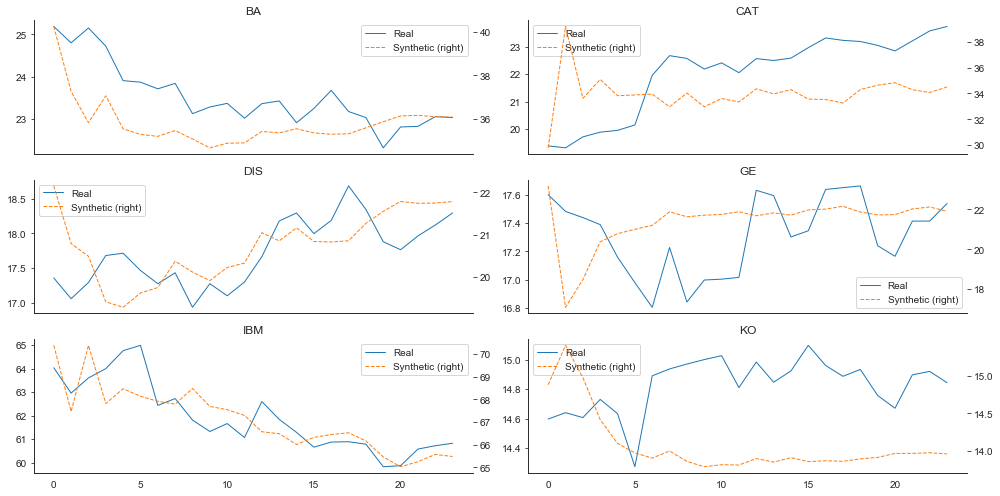

In [89]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
axes = axes.flatten()
index = list(range(1, 25))
synthetic = generated_data[np.random.randint(n_windows)]
idx = np.random.randint(len(df) - seq_len)
real = df.iloc[idx: idx + seq_len]
for j, ticker in enumerate(tickers):
    (pd.DataFrame({'Real': real.iloc[:, j].values,
                   'Synthetic': synthetic[:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1))
    sns.despine()
fig.tight_layout();